<a href="https://colab.research.google.com/github/BlinkovYevhenGit/CE888_Repository/blob/main/Assignment%201/Multi_Class_Tweet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install nltk

In [2]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
from IPython.display import clear_output
from sklearn.metrics import recall_score, f1_score, get_scorer
import nltk
import random
import string
from nltk import re
import pandas as pd
import seaborn as sns
import en_core_web_sm
from nltk.stem import WordNetLemmatizer
import re
import string

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
stemmer = WordNetLemmatizer() # initialisation of a lemmatiser that detaches lemmas from words
digits = string.digits  #a list of digits from 0 to 9
verbose=1
chars = re.escape(string.punctuation)

In [5]:
chars

'!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~'

In [17]:
def preprocess(tweet, do_pre_processing):
    tweet_list= []
    for t in tweet.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        tweet_list.append(t.strip())
        
    if do_pre_processing:
      prepared_tweet = " ".join(tweet_list)
      # print(prepared_tweet)
      tweet_list=re.sub("["+chars+"“”‘]","",prepared_tweet).split(" ")
      tweet_list[:] = [item for item in tweet_list if item != '']
      tweet_list=clean_tweet(tweet_list)
    return " ".join(tweet_list), tweet_list

In [7]:
def load_data(link, is_csv=False):
  with urllib.request.urlopen(link) as f:
    html = f.read().decode('utf-8').split("\n")
    if is_csv:
       csvreader = csv.reader(html, delimiter='\t')
       return csvreader
    return html

In [8]:
def clean_word(raw_word):
    word=raw_word.lower()
    
    #Lemmatisation of words
    word=stemmer.lemmatize(word)
    
    #Elimination of stop-words or other words(punctuation, numbers, tiny words, detached letters) 
    #that make up a noise in input data
    if any(map(str.isdigit, word)): 
        return None
    else:
        return word

In [9]:
def clean_tweet(text):
    for w in text[:]: #cleaning every word in the text
        word_res=clean_word(w) 
        if word_res!=None:
            text[text.index(w)]=word_res.strip() #returning back the cleaned word
        else: #removing noisy word from the text 
            text.remove(w) 
    return text

In [19]:
def classify_many(xtexts, task, do_pre_processing):
  MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
  model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
  tokenizer = AutoTokenizer.from_pretrained(MODEL)
  ypred=[]
  text_num=0
  for text in xtexts:
    # text_num+=1
    # print("Analysing",text_num,"- text from",len(xtexts))
    text, words_list = preprocess(text,do_pre_processing)
    encoded_input = tokenizer(text, return_tensors='tf')
    output = model(encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    l = labels[ranking[0]]
    # s = scores[ranking[0]]
    ypred.append(l)
    # clear_output(wait=True)
    # print(f"{1} {l} {np.round(float(s), 4)}")

  return ypred 

# RoBERTa - base model testing on chosen datasets

In [11]:
tasks=["sentiment","emotion","emoji"]

In [12]:
metrics={"sentiment":lambda y_true,y_pred : recall_score(y_true=y_true,y_pred=y_pred, average="macro"),"emotion":lambda y_true,y_pred : f1_score(y_true=y_true,y_pred=y_pred, average="macro"),"emoji":lambda y_true,y_pred : f1_score(y_true=y_true,y_pred=y_pred, average="macro")}

In [23]:
for task in tasks:
  print("Performing "+task,"task")
  mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
  test_tweets_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_text.txt"
  test_labels_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_labels.txt"

  # download label mapping
  csvreader = load_data(mapping_link, is_csv=True)
  labels = [row[1] for row in csvreader if len(row) > 1]
  mapping={str(key):value for key,value in enumerate(labels)}

  # download tweets
  test_tweets = load_data(test_tweets_link)

  # download tweets labels
  test_labels = load_data(test_labels_link)

  y_pred= classify_many(test_tweets[:300], task, False)
  y_true=[]
  for i in range(0, len(y_pred)):
    y_true.append(mapping[test_labels[i]])
    # print(i,"Predicted - ", y_pred[i], ", Expected - ", mapping[test_labels[i]])

  print("An example of classification for the task -", task)
  print("Tweet:")
  print(test_tweets[0])
  print(1,"Predicted - ", y_pred[0], ", Expected - ", mapping[test_labels[0]])
  print()

  print("Metric value:", metrics[task](y_true,y_pred))

  print("Attempting pre-processing...")
  y_pred_pre_processed=classify_many(test_tweets[:300], task, True)
  y_true=[]

  for i in range(0, len(y_pred_pre_processed)):
    y_true.append(mapping[test_labels[i]])
    # print(i,"Predicted - ", y_pred[i], ", Expected - ", mapping[test_labels[i]])
  print("An example of classification for the task -", task," on the pre-processed data")
  print("Tweet:")
  print(test_tweets[0])
  print(1,"Predicted - ", y_pred_pre_processed[0], ", Expected - ", mapping[test_labels[0]])
  print()
  print(metrics[task](y_true,y_pred_pre_processed),":")
 
  

Performing sentiment task


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


An example of classification for the task - sentiment
Tweet:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 
1 Predicted -  negative , Expected -  neutral

Metric value: 0.7170756477821696
Attempting pre-processing...


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


An example of classification for the task - sentiment  on the pre-processed data
Tweet:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 
1 Predicted -  negative , Expected -  neutral

0.6625494071146245 :
Performing emotion task


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


An example of classification for the task - emotion
Tweet:
#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse 
1 Predicted -  sadness , Expected -  sadness

Metric value: 0.7965684600751184
Attempting pre-processing...


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


An example of classification for the task - emotion  on the pre-processed data
Tweet:
#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse 
1 Predicted -  sadness , Expected -  sadness

0.7901440522871567 :
Performing emoji task


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emoji.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


An example of classification for the task - emoji
Tweet:
en Pelham Parkway
1 Predicted -  😍 , Expected -  😂

Metric value: 0.26978635721206096
Attempting pre-processing...


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emoji.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


An example of classification for the task - emoji  on the pre-processed data
Tweet:
en Pelham Parkway
1 Predicted -  😍 , Expected -  😂

0.27636124709278675 :


# Data Exploration Part

##1. Labels distribution in different datasets

In [24]:
import collections
from matplotlib import pyplot as plt 

Performing sentiment task
Amount of tweets in the sentiment dataset - 12285


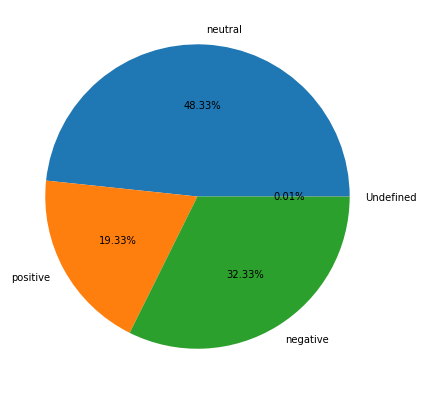

Performing emotion task
Amount of tweets in the emotion dataset - 1422


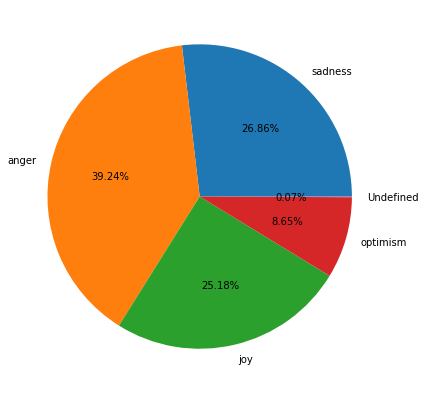

Performing emoji task
Amount of tweets in the emoji dataset - 50001
{'0': '❤', '1': '😍', '2': '😂', '3': '💕', '4': '🔥', '5': '😊', '6': '😎', '7': '✨', '8': '💙', '9': '😘', '10': '📷', '11': '🇺🇸', '12': '☀', '13': '💜', '14': '😉', '15': '💯', '16': '😁', '17': '🎄', '18': '📸', '19': '😜'}


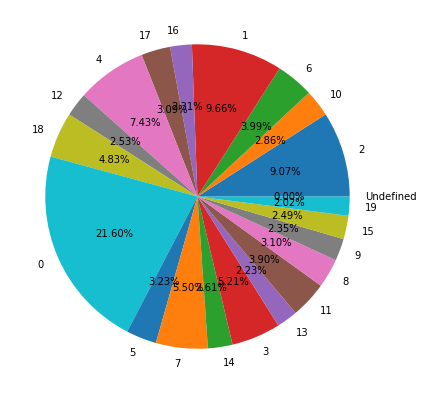

In [25]:
for task in tasks:
  print("Performing "+task,"task")
  mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
  test_tweets_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_text.txt"
  test_labels_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_labels.txt"

  # download label mapping
  csvreader = load_data(mapping_link, is_csv=True)
  labels = [row[1] for row in csvreader if len(row) > 1]
  mapping={str(key):value for key,value in enumerate(labels)}

  # download tweets
  test_tweets = load_data(test_tweets_link)
  print("Amount of tweets in the "+task+" dataset -",len(test_tweets))

  # download tweets labels
  test_labels = load_data(test_labels_link)
  if task!="emoji":
    test_labels_names=[mapping[item] if item in mapping else "Undefined" for item in test_labels]
  else:
    print(mapping)
    test_labels_names=[item if item in mapping else "Undefined" for item in test_labels]
  c = collections.Counter(test_labels_names)
  # Creating pie chart 
  fig = plt.figure(figsize =(10, 7)) 
  plt.pie(c.values(), labels = c.keys(),autopct='%1.2f%%') 

  # show plot 
  plt.show() 



## 2. Demonstration of pre-processing 

In [26]:
for task in tasks:
  print("Performing "+task,"task")
  mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
  test_tweets_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_text.txt"
  test_labels_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_labels.txt"

  # download label mapping
  csvreader = load_data(mapping_link, is_csv=True)
  labels = [row[1] for row in csvreader if len(row) > 1]
  mapping={str(key):value for key,value in enumerate(labels)}

  # download tweets
  test_tweets = load_data(test_tweets_link)

  # download tweets labels
  test_labels = load_data(test_labels_link)

  for index, item in enumerate(test_tweets[:10]):
    print(str(index+1)+".")
    print(" Original tweet:")
    print(item)
    print()
    i1,i2=preprocess(item, do_pre_processing=True)
    print(" Processed tweet")
    print(i1)
    print(" List of tokens:")
    print(i2)
    print("---------------")
  print("<===================================================>")

Performing sentiment task
1.
 Original tweet:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 

 Processed tweet
what do these naked pic have to do with anything theyre not even like that
 List of tokens:
['what', 'do', 'these', 'naked', 'pic', 'have', 'to', 'do', 'with', 'anything', 'theyre', 'not', 'even', 'like', 'that']
---------------
2.
 Original tweet:
OH: “I had a blue penis while I was this” [playing with Google Earth VR] 

 Processed tweet
oh i had a blue penis while i wa this playing with google earth vr
 List of tokens:
['oh', 'i', 'had', 'a', 'blue', 'penis', 'while', 'i', 'wa', 'this', 'playing', 'with', 'google', 'earth', 'vr']
---------------
3.
 Original tweet:
@user @user That's coming, but I think the victims are going to be Medicaid recipients. 

 Processed tweet
thats coming but i think the victim are going to be medicaid recipient
 List of tokens:
['thats', 'coming', 'but', 'i', 'think', 'the', 'victim', 'are', 'goi

https://medium.com/analytics-vidhya/hugging-face-transformers-how-to-use-pipelines-10775aa3db7e
https://tomaxent.com/2018/04/27/Micro-and-Macro-average-of-Precision-Recall-and-F-Score/